The goal of this notebook is to get comfortable using controlnet in diffuers.

Most code is taken from https://huggingface.co/blog/controlnet

---

In [2]:
import torch

In [3]:
device = "cpu"
device_dtype = torch.float32

We will use the famous painting "Girl With A Pearl" for this example. So, let's download the image and take a look:

In [4]:
from diffusers.utils import load_image

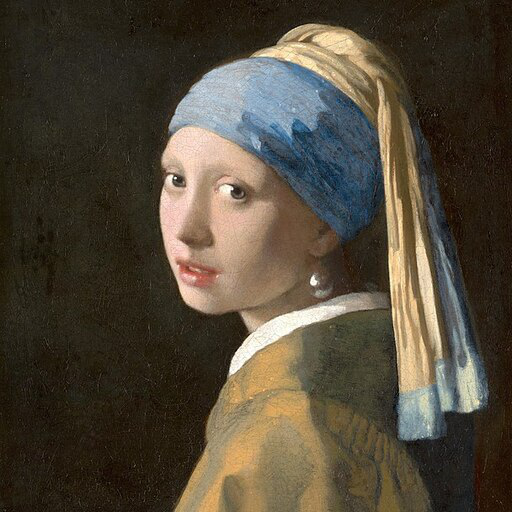

In [5]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

Next, we will put the image through the canny pre-processor:

In [6]:
import cv2
from PIL import Image
import numpy as np

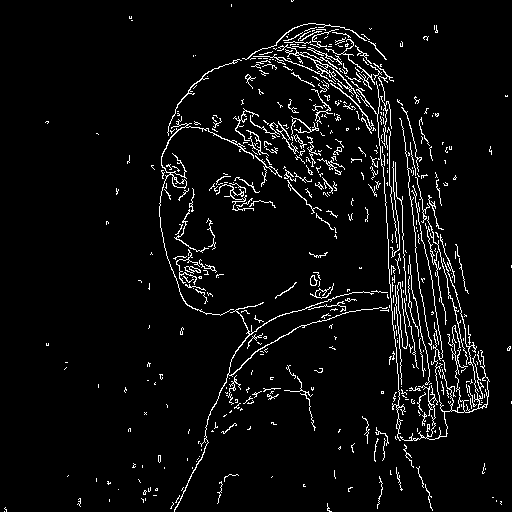

In [7]:
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

Now, we load runwaylml/stable-diffusion-v1-5 as well as the ControlNet model for canny edges.

In [8]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

In [9]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=device_dtype)

In [10]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=device_dtype
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Instead of using Stable Diffusion's default PNDMScheduler, we use one of the currently fastest diffusion model schedulers, called UniPCMultistepScheduler.

In [11]:
# Lets use the standard scheduler for now, to ensure it is not the cause of the jupyter kernel dying
#from diffusers import UniPCMultistepScheduler

In [12]:
#pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [13]:
# doesn't work with mps
#pipe.enable_model_cpu_offload()

In [14]:
# doesn't work with mps
# pipe.enable_xformers_memory_efficient_attention()

Let's first create a simple helper function to display images as a grid.

In [15]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

Next, we define the input prompts and set a seed for reproducability.

In [16]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Barack Obama", "Angela Merkel", "Muhammad Ali", "Anne Hathaway"]]

In [24]:
prompt = prompt[0:1] # only use 1 prompt, as 4 togehter don't run

In [25]:
n_prompt = len(prompt)

In [26]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(n_prompt)]

Finally, we can run the pipeline and display the image!

In [28]:
import time
start_time = time.time()

In [29]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * n_prompt,
    num_inference_steps=20,
    generator=generator,
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 105.49368190765381 seconds


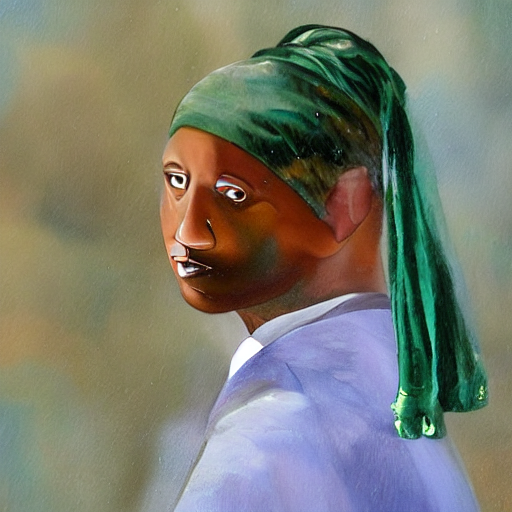

In [31]:
image_grid(output.images, 1, 1)